<a href="https://colab.research.google.com/github/IvanSalinas2000/Preprocesamiento-y-clasificacion-de-datos/blob/main/Proyecto/ProyectoChatBot%20Borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto
##Generación Automática de Respuestas para Preguntas Médicas usando T5
###Iván Gabriel Salinas Castillo 1856735

In [15]:
!pip install --upgrade transformers sentencepiece
!pip uninstall -y protobuf
!pip install protobuf==3.20.*
!pip install --upgrade transformers datasets
!pip install spacy
!python -m spacy download en_core_web_sm
# Instalar las librerías necesarias
!pip install rouge-score sacrebleu evaluate torchsummary
#https://www.kaggle.com/datasets/jpmiller/layoutlm/data
# Importar librerías necesarias
import torch  #para aprendizaje profundo
import numpy as np
import pandas as pd
import re  # Expresiones regulares para procesamiento de texto
import tensorflow as tf
import evaluate  # Librería para métricas de evaluación
import seaborn as sns
import matplotlib.pyplot as plt
import warnings  #suprimir advertencias

# Importar componentes de Transformers de Hugging Face
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

# Importar librerías para manejo de datos
from datasets import Dataset

# dividir el dataset en entrenamiento y prueba
from sklearn.model_selection import train_test_split

#  para pérdida, optimización y manejo de datos
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary  # Resumen de modelos en PyTorch

# para manejar diccionarios con valores por defecto
from collections import defaultdict

# Suprimir advertencias para mantener la salida limpia
warnings.filterwarnings("ignore")
!nvidia-smi
!pip check

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
/bin/bash: line 1: nvidia-smi: command not found
ipython 7.34.0 requires jedi, which is not installed.
gcsfs 2025.3.0 has requirement fsspec==2025.3.0, but you have fsspec 2024.12.0.
torch 2.6.0+cu124 has requirement nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2.
torch 2.6.0+cu124 has requirement nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cuda-nvrtc-cu12==1

In [11]:
# Cargar el dataset desde un archivo CSV
df = pd.read_csv('/content/medquad.csv')

# Mostrar una muestra de los datos para comprender su estructura
print("Muestra de Datos:")
print(df.head())

# Verificar valores nulos en el dataset
print("Valores Nulos en los Datos:")
print(df.isnull().sum())

# Lista de palabras clave para filtrar preguntas relevantes
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Convertir todas las preguntas a minúsculas para una filtración consistente
df['question'] = df['question'].str.lower()

# Filtrar filas donde la pregunta comience con una palabra clave
df = df[df['question'].str.split().str[0].isin(question_words)]

# Restablecer el índice después de la filtración
df = df.reset_index(drop=True)

# Verificar filas duplicadas en el dataset
duplicates = df.duplicated()
print(f"Número de filas duplicadas: {duplicates.sum()}")

# Eliminar filas duplicadas para asegurar la unicidad de los datos
df = df.drop_duplicates()

# Restablecer el índice después de eliminar duplicados
df.reset_index(drop=True, inplace=True)

# Eliminar columnas innecesarias ('source' y 'focus_area') para simplificar el dataset
df = df.drop(columns=['source', 'focus_area'])

# Mostrar información del dataset (columnas, tipos de datos y valores no nulos)
print("Información de la Tabla:")
print(df.info())

# Eliminar filas duplicadas basadas en las columnas 'question' y 'answer'
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

# Eliminar filas con valores nulos en las columnas 'question' o 'answer'
df = df.dropna(subset=['question', 'answer']).reset_index(drop=True)

# Rellenar valores nulos restantes con cadenas vacías y convertir a tipo string
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Definir una función para limpiar el texto eliminando paréntesis y espacios adicionales
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Eliminar texto dentro de paréntesis
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Normalizar espacios y convertir a minúsculas
    return text

# Aplicar la función de limpieza a las columnas 'question' y 'answer'
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Refinar aún más el texto asegurando minúsculas, eliminación de espacios y normalización
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

# Verificar valores nulos después de la limpieza
print("Valores Nulos en los Datos Después de la Limpieza:")
print(df.isnull().sum())

# Contar el número de preguntas y respuestas únicas en el dataset
print(f"Preguntas únicas: {df['question'].nunique()}")
print(f"Respuestas únicas: {df['answer'].nunique()}")

# Mostrar información final del dataset y una muestra de los datos limpiados
print("Información Final del Dataset:")
df.info()
print("Muestra de Datos Final:")
df.head()

Muestra de Datos:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Valores Nulos en los Datos:
question       0
answer         5
source         0
focus_area    14
dtype: int64
Número de filas duplicadas: 48
Información de la Tabla:
<class 'pandas.co

,question,answer
0,what is glaucoma ?,glaucoma is a group of diseases that can damag...
1,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea..."
2,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...
3,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ..."
4,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...


##Estadisticas descriptivas


Estadísticas de longitud:
       q_length  a_length
count  13857.00  13857.00
mean       8.07    200.11
std        2.43    245.79
min        3.00      1.00
25%        6.00     73.00
50%        8.00    137.00
75%       10.00    251.00
max       23.00   3612.00


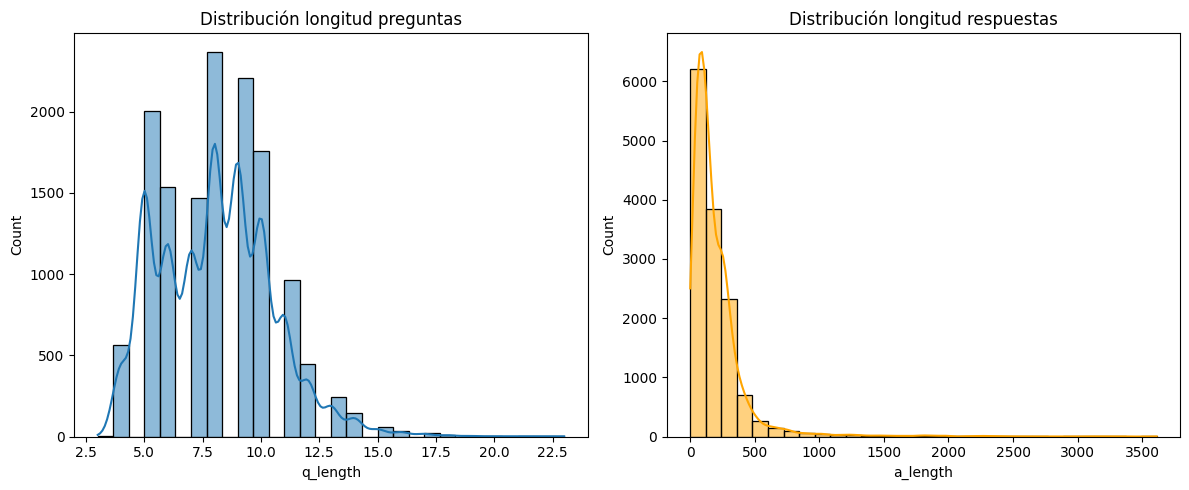


Top 20 palabras en preguntas:
[('?', 13574), ('what', 10634), ('are', 7003), ('the', 6350), ('is', 4993), ('for', 3156), ('of', 3097), ('syndrome', 3083), ('symptoms', 2669), ('to', 2167), ('treatments', 2014), ('how', 1901), ('people', 1118), ('by', 1112), ('many', 1109), ('affected', 1109), ('genetic', 1097), ('related', 1088), ('changes', 1087), ('disease', 1078)]

Top 20 palabras en respuestas:
[('the', 163310), ('of', 106992), ('and', 67188), ('a', 65840), ('in', 59022), ('-', 52850), ('is', 50045), ('to', 47898), ('or', 37251), ('are', 26573), ('that', 26015), ('may', 24947), ('for', 23650), ('with', 23009), ('be', 20010), ('have', 18628), ('people', 17228), ('can', 15976), ('as', 15021), ('these', 14748)]

Distribución de tipos de preguntas:
0
what     0.759544
how      0.136898
is       0.064588
do       0.021289
who      0.017536
where    0.000072
are      0.000072
Name: proportion, dtype: float64


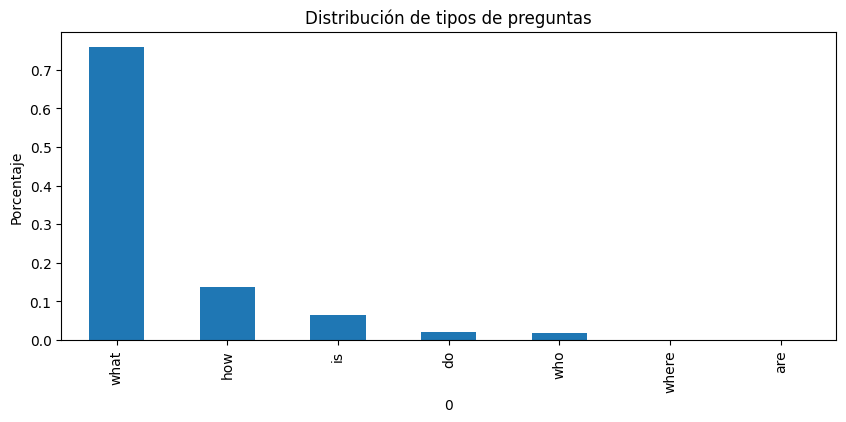


Correlación entre longitud de pregunta y respuesta: 0.06


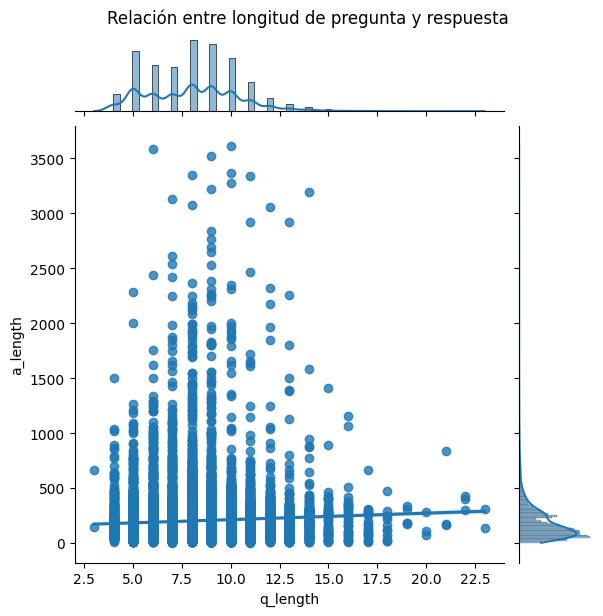


Entidades médicas más frecuentes:
[('nasal bridge', 244), ('nih', 203), ('the national institute of neurological disorders', 139), ('nih: national institute of diabetes', 87), ('nih: national institute of neurological disorders', 47), ('men1', 46), ('fda', 43), ('ttp', 38), ('bmi', 37), ('nih: national institute of allergy', 37), ('cdc', 36), ('nih: national institute of arthritis', 34), ('nasal', 30), ('nih: national institute of child health and human development', 30), ('wilson', 28)]

Distribución por categorías médicas:
diagnosis     3282
treatment     2051
prevention     448
anatomy         88
dtype: int64


In [16]:
# Longitud de preguntas y respuestas en tokens
df['q_length'] = df['question'].apply(lambda x: len(x.split()))
df['a_length'] = df['answer'].apply(lambda x: len(x.split()))

print("\nEstadísticas de longitud:")
print(df[['q_length', 'a_length']].describe().round(2))

# Visualización
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['q_length'], bins=30, kde=True)
plt.title('Distribución longitud preguntas')

plt.subplot(1, 2, 2)
sns.histplot(df['a_length'], bins=30, kde=True, color='orange')
plt.title('Distribución longitud respuestas')
plt.tight_layout()
plt.show()

from collections import Counter

# Palabras más comunes en preguntas
q_words = ' '.join(df['question']).lower().split()
q_word_counts = Counter(q_words).most_common(20)

# Palabras más comunes en respuestas
a_words = ' '.join(df['answer']).lower().split()
a_word_counts = Counter(a_words).most_common(20)

print("\nTop 20 palabras en preguntas:")
print(q_word_counts)

print("\nTop 20 palabras en respuestas:")
print(a_word_counts)

# Clasificación por palabra inicial
question_types = df['question'].str.extract(r'^(what|who|why|when|where|how|is|are|does|do|can|will)', flags=re.IGNORECASE)[0]
question_dist = question_types.value_counts(normalize=True).sort_values(ascending=False)

print("\nDistribución de tipos de preguntas:")
print(question_dist)

# Visualización
question_dist.plot(kind='bar', figsize=(10, 4), title='Distribución de tipos de preguntas')
plt.ylabel('Porcentaje')
plt.show()

# Correlación longitud pregunta-respuesta
correlation = df['q_length'].corr(df['a_length'])
print(f"\nCorrelación entre longitud de pregunta y respuesta: {correlation:.2f}")

# Gráfico de dispersión
sns.jointplot(x='q_length', y='a_length', data=df, kind='reg', height=6)
plt.suptitle('Relación entre longitud de pregunta y respuesta', y=1.02)
plt.show()



import spacy
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['DISEASE', 'CHEMICAL', 'ORG']]

# Extraer entidades médicas
df['q_entities'] = df['question'].apply(extract_entities)
df['a_entities'] = df['answer'].apply(extract_entities)

# Conteo de entidades
all_entities = [item for sublist in df['a_entities'] for item in sublist]
entity_counts = Counter(all_entities).most_common(15)

print("\nEntidades médicas más frecuentes:")
print(entity_counts)

# Patrones para identificar categorías
patterns = {
    'diagnosis': r'diagnos|signs|symptoms',
    'treatment': r'treat|therapy|drug|medication',
    'prevention': r'prevent|avoid|risk',
    'anatomy': r'organ|body part|muscle|bone'
}

# Clasificación automática
for category, pattern in patterns.items():
    df[category] = df['question'].str.contains(pattern, case=False)

# Conteo por categoría
category_counts = df[list(patterns.keys())].sum().sort_values(ascending=False)
print("\nDistribución por categorías médicas:")
print(category_counts)

#Modelo T5

In [ ]:
# Definir el nombre del modelo y cargar la configuración de T5-base
nombre_modelo = "t5-base"
configuracion = T5Config.from_pretrained(nombre_modelo)

# Personalizar la configuración
configuracion.dropout_rate = 0.1  # Establecer una tasa de dropout de 0.1 para regularización
configuracion.feed_forward_proj = "gelu"  # Usar activación GELU en las capas de feed-forward

# Cargar el modelo T5 pre-entrenado con la configuración personalizada
modelo = T5ForConditionalGeneration.from_pretrained(nombre_modelo, config=configuracion)

# Cargar el tokenizador del modelo T5
tokenizador = T5Tokenizer.from_pretrained(nombre_modelo)

# Ajustar explícitamente el tamaño del vocabulario del modelo al del tokenizador
modelo.resize_token_embeddings(len(tokenizador))

# Imprimir un resumen detallado de la arquitectura del modelo
print("\nResumen detallado del modelo:")
print("=" * 50)

def resumir_modelo_por_tipo(modelo):
    """
    Resume el modelo contando el número de capas y parámetros por tipo de capa.
    """
    resumen_capas = defaultdict(int)  # Cuenta el número de capas por tipo
    resumen_parametros = defaultdict(int)  # Cuenta el número de parámetros por tipo de capa

    for nombre, modulo in modelo.named_modules():
        tipo_capa = type(modulo).__name__  # Obtener el tipo del módulo actual
        resumen_capas[tipo_capa] += 1  # Incrementar el conteo de esta capa
        resumen_parametros[tipo_capa] += sum(p.numel() for p in modulo.parameters())  # Sumar parámetros

    # Imprimir la tabla de resumen
    print(f"{'Tipo de Capa':<30}{'Cantidad':<10}{'Parámetros':<15}")
    print("=" * 55)
    for tipo_capa, cantidad in resumen_capas.items():
        print(f"{tipo_capa:<30}{cantidad:<10}{resumen_parametros[tipo_capa]:<15,}")

resumir_modelo_por_tipo(modelo)

# Definir una función de preprocesamiento para la tarea seq2seq
def funcion_preprocesamiento(lote):
    """
    Preprocesa el conjunto de datos tokenizando las entradas y las etiquetas.
    """
    # Formatear las preguntas y respuestas
    entradas = [f"responde la siguiente pregunta: {q}" for q in lote['question']]
    etiquetas = [f"{a}" for a in lote['answer']]

    # Tokenizar las entradas
    entradas_modelo = tokenizador(
        entradas,
        max_length=128,  # Truncar o rellenar hasta una longitud máxima de 128
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    # Tokenizar las etiquetas
    with tokenizador.as_target_tokenizer():
        etiquetas_modelo = tokenizador(
            etiquetas,
            max_length=64,  # Truncar o rellenar hasta una longitud máxima de 64
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

    # Reemplazar los tokens de padding con -100 para que sean ignorados por la función de pérdida
    etiquetas_modelo["input_ids"][etiquetas_modelo["input_ids"] == tokenizador.pad_token_id] = -100
    entradas_modelo["labels"] = etiquetas_modelo["input_ids"]
    return entradas_modelo

# Dividir el dataset en conjuntos de entrenamiento y validación
df_entrenamiento, df_validacion = train_test_split(df, test_size=0.15, random_state=42)

# Convertir los DataFrames de pandas en objetos Dataset de Hugging Face
dataset_entrenamiento = Dataset.from_pandas(df_entrenamiento)
dataset_validacion = Dataset.from_pandas(df_validacion)

# Preprocesar los datasets de entrenamiento y validación
dataset_entrenamiento = dataset_entrenamiento.map(
    funcion_preprocesamiento,
    batched=True,
    batch_size=32,  # Procesar en lotes de 32
    remove_columns=dataset_entrenamiento.column_names,  # Eliminar columnas originales
    num_proc=2,
)

dataset_validacion = dataset_validacion.map(
    funcion_preprocesamiento,
    batched=True,
    batch_size=32,
    remove_columns=dataset_validacion.column_names,
    num_proc=2,
)

# Definir los argumentos de entrenamiento
argumentos_entrenamiento = Seq2SeqTrainingArguments(
    output_dir="./resultados",
    evaluation_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.2,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_steps=200,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    gradient_accumulation_steps=4,
    max_grad_norm=0.5,
    optim="adamw_torch_fused",
    generation_max_length=128,
    generation_num_beams=4,
    dataloader_num_workers=4,
    group_by_length=False,
    remove_unused_columns=True,
    label_smoothing_factor=0.05,
)

# Inicializar el data collator para tareas seq2seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizador,
    model=modelo,
    padding='longest',
    return_tensors="pt",
)

def calcular_metricas(eval_pred, tokenizador):
    """
    Calcula las métricas Exact Match, BLEU y ROUGE-L.
    """
    predicciones, etiquetas = eval_pred
    pred_decodificadas = tokenizador.batch_decode(predicciones, skip_special_tokens=True)
    etiquetas = np.where(etiquetas != -100, etiquetas, tokenizador.pad_token_id)
    etiquetas_decodificadas = tokenizador.batch_decode(etiquetas, skip_special_tokens=True)

    exact_match = np.mean([p == l for p, l in zip(pred_decodificadas, etiquetas_decodificadas)])
    bleu = evaluate.load("bleu").compute(predictions=pred_decodificadas, references=[[l] for l in etiquetas_decodificadas])["bleu"]
    rouge = evaluate.load("rouge").compute(predictions=pred_decodificadas, references=etiquetas_decodificadas)["rougeL"]

    return {"exact_match": exact_match, "BLEU": bleu, "ROUGE-L": rouge}

# Entrenar el modelo
entrenador = Seq2SeqTrainer(
    model=modelo,
    args=argumentos_entrenamiento,
    train_dataset=dataset_entrenamiento,
    eval_dataset=dataset_validacion,
    tokenizer=tokenizador,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: calcular_metricas(eval_pred, tokenizador),
)

entrenador.train()

# Guardar el modelo entrenado y el tokenizador
entrenador.save_model("./t5_chatbot_model")
tokenizador.save_pretrained("./t5_chatbot_tokenizer")

# Guardar el estado del modelo
model_path = "./t5_chatbot_model.h5"
torch.save(modelo.state_dict(), model_path)

# Guardar el historial de entrenamiento
log_history = entrenador.state.log_history

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]


Resumen detallado del modelo:
Tipo de Capa                  Cantidad  Parámetros     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map (num_proc=2):   0%|          | 0/11778 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2079 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,No log,2.766497,0.002886,0.124380,0.276395


IndexError: piece id is out of range.

In [ ]:
ls ./resultados/


checkpoint-2208/


In [ ]:
!rm -rf ./resultados/trainer_state.json

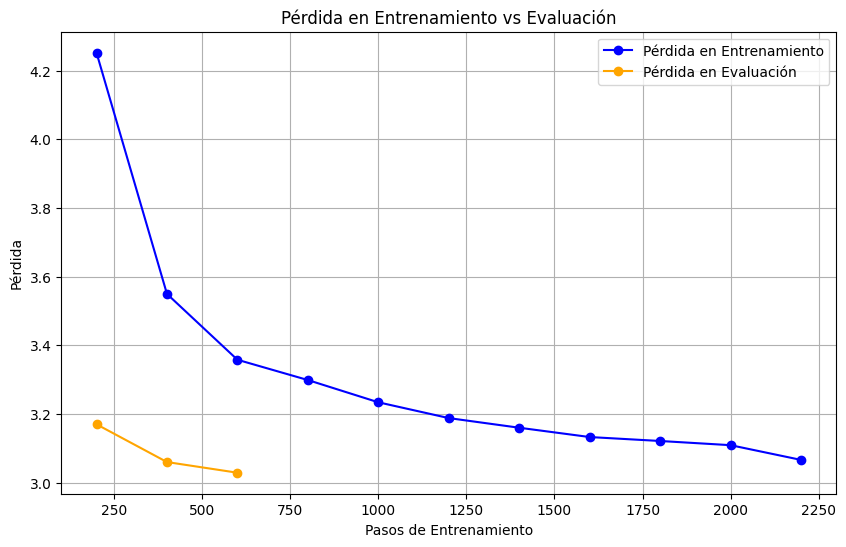

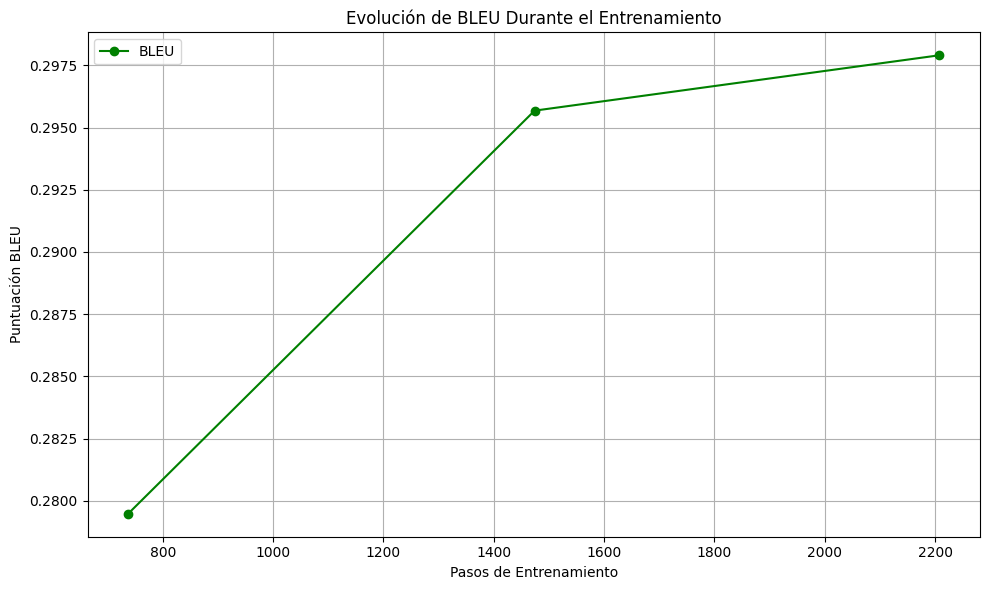

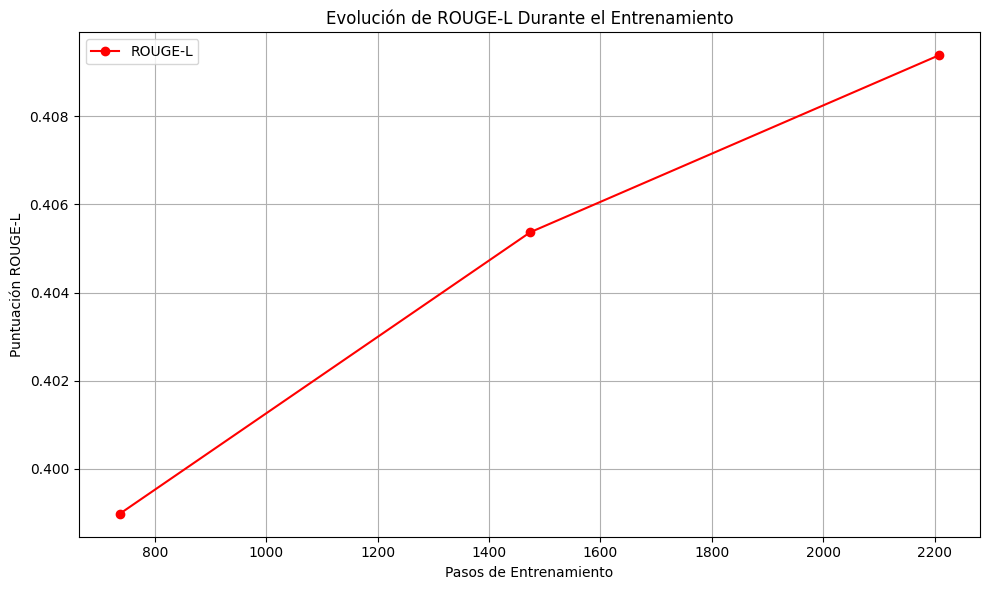

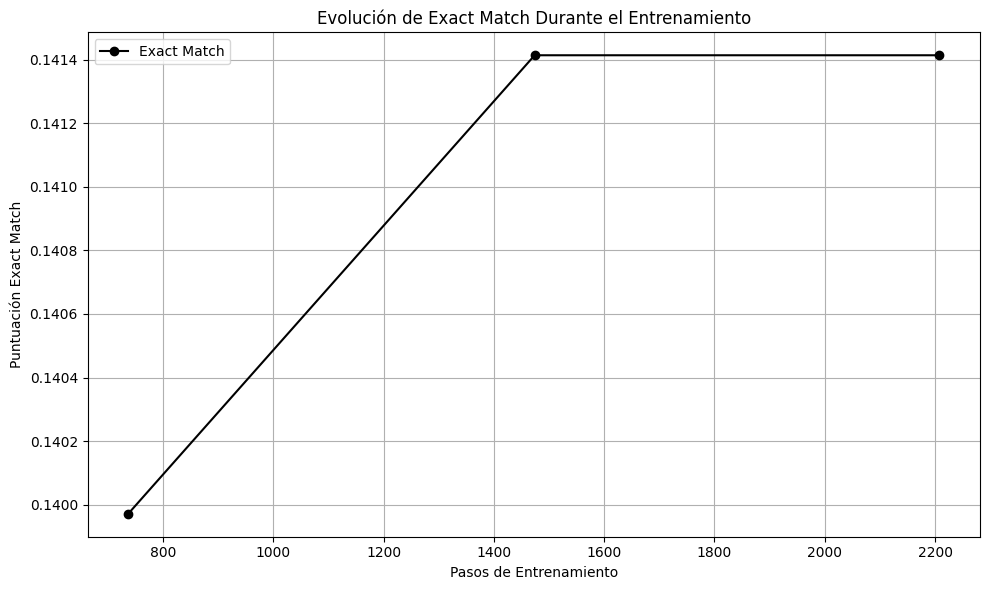

In [ ]:
# Inicializar listas para almacenar métricas de entrenamiento y evaluación
train_loss = []  # Pérdida durante el entrenamiento
eval_loss = []  # Pérdida durante la evaluación
eval_bleu = []  # Puntuación BLEU en la evaluación
eval_exact_match = []  # Puntuación Exact Match en la evaluación
eval_rogue = []  # Puntuación ROUGE-L en la evaluación
steps = []  # Número de pasos de entrenamiento
eval_steps = []  # Número de pasos en la evaluación
# Extraer métricas del historial de entrenamiento
for log in log_history:
    if "loss" in log:  # Si hay pérdida en el registro de entrenamiento
        train_loss.append(log["loss"])  # Guardar la pérdida de entrenamiento
        steps.append(log["step"])  # Guardar el número de paso correspondiente
    if "eval_loss" in log:  # Si hay pérdida en la evaluación
        eval_loss.append(log["eval_loss"])  # Guardar la pérdida de evaluación
        eval_steps.append(log["step"])  # Guardar el número de paso correspondiente
    if "eval_BLEU" in log:  # Si hay puntuación BLEU en la evaluación
        eval_bleu.append(log["eval_BLEU"])  # Guardar la puntuación BLEU
    if "eval_ROUGE-L" in log:  # Si hay puntuación ROUGE-L
        eval_rogue.append(log["eval_ROUGE-L"])  # Guardar la puntuación ROUGE-L
    if "eval_exact_match" in log:  # Si hay puntuación Exact Match
        eval_exact_match.append(log["eval_exact_match"])  # Guardar la puntuación Exact Match
# Gráfico de la pérdida en entrenamiento vs evaluación
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Pérdida en Entrenamiento", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Pérdida en Evaluación", color="orange", marker="o")
plt.xlabel("Pasos de Entrenamiento")
plt.ylabel("Pérdida")
plt.title("Pérdida en Entrenamiento vs Evaluación")
plt.legend()
plt.grid(True)
plt.show()
# Gráfico de la puntuación BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")
plt.xlabel("Pasos de Entrenamiento")
plt.ylabel("Puntuación BLEU")
plt.title("Evolución de BLEU Durante el Entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Gráfico de la puntuación ROUGE-L
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_rogue, label="ROUGE-L", marker="o", linestyle="-", color="red")
plt.xlabel("Pasos de Entrenamiento")
plt.ylabel("Puntuación ROUGE-L")
plt.title("Evolución de ROUGE-L Durante el Entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Gráfico de la puntuación Exact Match
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_exact_match, label="Exact Match", marker="o", linestyle="-", color="black")
plt.xlabel("Pasos de Entrenamiento")
plt.ylabel("Puntuación Exact Match")
plt.title("Evolución de Exact Match Durante el Entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Definir rutas del modelo y del tokenizador guardados
model_path = "/content/t5_chatbot_model"
tokenizer_path = "/content/t5_chatbot_tokenizer"

# Verificar si las rutas existen
if not os.path.exists(model_path) or not os.path.exists(tokenizer_path):
    raise FileNotFoundError("Model or tokenizer path does not exist. Check file paths.")

# Cargar el tokenizador desde la ruta guardada
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

# Cargar el modelo desde la ruta guardada
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Configurar el modelo en modo de evaluación
model.eval()

def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
    """
    Genera una respuesta a una pregunta dada usando muestreo Top-K y Top-P.

    Args:
        question (str): Pregunta de entrada a la que se generará una respuesta.
        model (T5ForConditionalGeneration): Modelo T5 preentrenado.
        tokenizer (T5Tokenizer): Tokenizador del modelo T5.
        max_length (int): Longitud máxima de la respuesta generada.
        top_k (int): Número de tokens con mayor probabilidad a considerar en Top-K.
        top_p (float): Umbral de probabilidad acumulativa en Top-P (nucleus sampling).
        temperature (float): Controla la aleatoriedad en el muestreo (mayor = más aleatorio).

    Returns:
        str: La respuesta generada.
    """
    # Formatear la pregunta para el modelo
    formatted_question = f"Answer the following question: {question}"

    # Tokenizar la pregunta de entrada
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",  # Retornar tensores de PyTorch
        padding=True,  # Añadir padding a las secuencias
        truncation=True,  # Truncar secuencias más largas que max_length
        max_length=128,  # Longitud máxima de la secuencia de entrada
    )

    # Generar una respuesta usando muestreo Top-K y Top-P
    outputs = model.generate(
        input_ids=inputs["input_ids"],  # IDs de los tokens de entrada
        attention_mask=inputs["attention_mask"],  # Máscara de atención
        max_length=max_length,  # Longitud máxima de la respuesta generada
        do_sample=True,  # Habilitar muestreo en lugar de búsqueda codiciosa o por haz (beam search)
        top_k=top_k,  # Muestreo Top-K: considerar los k tokens más probables
        top_p=top_p,  # Muestreo Top-P: considerar el menor conjunto de tokens cuya probabilidad acumulada sea >= top_p
        temperature=temperature,  # Control de aleatoriedad en la generación
        pad_token_id=tokenizer.pad_token_id,  # ID del token de padding
    )

    # Decodificar la respuesta generada en una cadena legible
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response

# Ejemplo de uso de la función
try:
    question = "What is Alzheimer's?"
    response = generate_response_top_k_top_p(question, model, tokenizer)
    print("Question:", question)
    print("Response:", response)
except Exception as e:
    print(f"Error generating response: {e}")

Question: What is Alzheimer's?
Response: Alzheimer's is a type of disease. it affects your brain and nervous system. it is common in a person with Alzheimer. it is caused by mutations in the ltp1 gene. some people have genetic problems based on their genetics and genetics., most people


In [ ]:
# Define una pregunta en ingles
question = "what is glaucoma?"
response = generate_response_top_k_top_p(question, model, tokenizer)

# Imprimir la pregunta y la respuesta generada
print("Question:", question)
print("Response:", response)

Question: what is glaucoma?
Response: glaucoma is a type of tumor that stretches towards the middle of the head. you can also see glaucoma in the hair, scalp, abdomen, elbow, and leg. glaucoma usually causes the eye to stop and rip or get it.


------

In [9]:
import pandas as pd
import re
import numpy as np
import torch
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    T5Config,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from collections import defaultdict
import evaluate

# Cargar el dataset desde un archivo CSV
df = pd.read_csv('/content/medquad.csv')

# Mostrar una muestra de los datos para comprender su estructura
print("Muestra de Datos:")
print(df.head())

# Verificar valores nulos en el dataset
print("Valores Nulos en los Datos:")
print(df.isnull().sum())

# Lista de palabras clave para filtrar preguntas relevantes
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Convertir todas las preguntas a minúsculas para una filtración consistente
df['question'] = df['question'].str.lower()

# Filtrar filas donde la pregunta comience con una palabra clave
df = df[df['question'].str.split().str[0].isin(question_words)]

# Restablecer el índice después de la filtración
df = df.reset_index(drop=True)

# Verificar filas duplicadas en el dataset
duplicates = df.duplicated()
print(f"Número de filas duplicadas: {duplicates.sum()}")

# Eliminar filas duplicadas para asegurar la unicidad de los datos
df = df.drop_duplicates()

# Restablecer el índice después de eliminar duplicados
df.reset_index(drop=True, inplace=True)

# Eliminar columnas innecesarias ('source' y 'focus_area') para simplificar el dataset
df = df.drop(columns=['source', 'focus_area'])

# Mostrar información del dataset (columnas, tipos de datos y valores no nulos)
print("Información de la Tabla:")
print(df.info())

# Eliminar filas duplicadas basadas en las columnas 'question' y 'answer'
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

# Eliminar filas con valores nulos en las columnas 'question' o 'answer'
df = df.dropna(subset=['question', 'answer']).reset_index(drop=True)

# Rellenar valores nulos restantes con cadenas vacías y convertir a tipo string
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Definir una función para limpiar el texto eliminando paréntesis y espacios adicionales
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Eliminar texto dentro de paréntesis
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Normalizar espacios y convertir a minúsculas
    return text

# Aplicar la función de limpieza a las columnas 'question' y 'answer'
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Refinar aún más el texto asegurando minúsculas, eliminación de espacios y normalización
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

# Eliminar respuestas vacías o demasiado cortas
df = df[df['answer'].str.strip().str.len() > 5]

# Verificar valores nulos después de la limpieza
print("Valores Nulos en los Datos Después de la Limpieza:")
print(df.isnull().sum())

# Contar el número de preguntas y respuestas únicas en el dataset
print(f"Preguntas únicas: {df['question'].nunique()}")
print(f"Respuestas únicas: {df['answer'].nunique()}")

# Mostrar información final del dataset y una muestra de los datos limpiados
print("Información Final del Dataset:")
df.info()
print("Muestra de Datos Final:")
df.head()

# Definir el nombre del modelo y cargar la configuración de T5-base
nombre_modelo = "t5-base"
configuracion = T5Config.from_pretrained(nombre_modelo)

# Personalizar la configuración
configuracion.dropout_rate = 0.1  # Establecer una tasa de dropout de 0.1 para regularización
configuracion.feed_forward_proj = "gelu"  # Usar activación GELU en las capas de feed-forward

# Cargar el modelo T5 pre-entrenado con la configuración personalizada
modelo = T5ForConditionalGeneration.from_pretrained(nombre_modelo, config=configuracion)

# Cargar el tokenizador del modelo T5
tokenizador = T5Tokenizer.from_pretrained(nombre_modelo)

# Ajustar explícitamente el tamaño del vocabulario del modelo al del tokenizador
modelo.resize_token_embeddings(len(tokenizador))

# Imprimir un resumen detallado de la arquitectura del modelo
print("\nResumen detallado del modelo:")
print("=" * 50)

def resumir_modelo_por_tipo(modelo):
    """
    Resume el modelo contando el número de capas y parámetros por tipo de capa.
    """
    resumen_capas = defaultdict(int)  # Cuenta el número de capas por tipo
    resumen_parametros = defaultdict(int)  # Cuenta el número de parámetros por tipo de capa

    for nombre, modulo in modelo.named_modules():
        tipo_capa = type(modulo).__name__  # Obtener el tipo del módulo actual
        resumen_capas[tipo_capa] += 1  # Incrementar el conteo de esta capa
        resumen_parametros[tipo_capa] += sum(p.numel() for p in modulo.parameters())  # Sumar parámetros

    # Imprimir la tabla de resumen
    print(f"{'Tipo de Capa':<30}{'Cantidad':<10}{'Parámetros':<15}")
    print("=" * 55)
    for tipo_capa, cantidad in resumen_capas.items():
        print(f"{tipo_capa:<30}{cantidad:<10}{resumen_parametros[tipo_capa]:<15,}")

resumir_modelo_por_tipo(modelo)

# Definir una función de preprocesamiento para la tarea seq2seq
def funcion_preprocesamiento(lote):
    """
    Preprocesa el conjunto de datos tokenizando las entradas y las etiquetas.
    """
    # Formatear las preguntas y respuestas
    entradas = [f"responde la siguiente pregunta: {q}" for q in lote['question']]
    etiquetas = [f"{a}" for a in lote['answer']]

    # Tokenizar las entradas
    entradas_modelo = tokenizador(
        entradas,
        max_length=128,  # Truncar o rellenar hasta una longitud máxima de 128
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    # Tokenizar las etiquetas
    with tokenizador.as_target_tokenizer():
        etiquetas_modelo = tokenizador(
            etiquetas,
            max_length=64,  # Truncar o rellenar hasta una longitud máxima de 64
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

    # Reemplazar los tokens de padding con -100 para que sean ignorados por la función de pérdida
    etiquetas_modelo["input_ids"][etiquetas_modelo["input_ids"] == tokenizador.pad_token_id] = -100
    entradas_modelo["labels"] = etiquetas_modelo["input_ids"]
    return entradas_modelo

# Dividir el dataset en conjuntos de entrenamiento y validación
df_entrenamiento, df_validacion = train_test_split(df, test_size=0.15, random_state=42)

# Convertir los DataFrames de pandas en objetos Dataset de Hugging Face
dataset_entrenamiento = Dataset.from_pandas(df_entrenamiento)
dataset_validacion = Dataset.from_pandas(df_validacion)

# Preprocesar los datasets de entrenamiento y validación
dataset_entrenamiento = dataset_entrenamiento.map(
    funcion_preprocesamiento,
    batched=True,
    batch_size=32,  # Procesar en lotes de 32
    remove_columns=dataset_entrenamiento.column_names,  # Eliminar columnas originales
    num_proc=2,
)

dataset_validacion = dataset_validacion.map(
    funcion_preprocesamiento,
    batched=True,
    batch_size=32,
    remove_columns=dataset_validacion.column_names,
    num_proc=2,
)

# Definir los argumentos de entrenamiento
argumentos_entrenamiento = Seq2SeqTrainingArguments(
    output_dir="./resultados",
    evaluation_strategy="epoch",
    save_total_limit=1,
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    lr_scheduler_type="cosine_with_restarts",
    warmup_ratio=0.2,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,
    logging_dir="./logs",
    logging_steps=200,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    gradient_accumulation_steps=4,
    max_grad_norm=0.5,
    optim="adamw_torch_fused",
    generation_max_length=128,
    generation_num_beams=4,
    dataloader_num_workers=4,
    group_by_length=False,
    remove_unused_columns=True,
    label_smoothing_factor=0.05,
)

# Inicializar el data collator para tareas seq2seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizador,
    model=modelo,
    padding='longest',
    return_tensors="pt",
)

def calcular_metricas(eval_pred, tokenizador):
    """
    Calcula las métricas Exact Match, BLEU y ROUGE-L.
    """
    predicciones, etiquetas = eval_pred
    pred_decodificadas = tokenizador.batch_decode(predicciones, skip_special_tokens=True)
    etiquetas = np.where(etiquetas != -100, etiquetas, tokenizador.pad_token_id)
    etiquetas_decodificadas = tokenizador.batch_decode(etiquetas, skip_special_tokens=True)

    exact_match = np.mean([p == l for p, l in zip(pred_decodificadas, etiquetas_decodificadas)])
    bleu = evaluate.load("bleu").compute(predictions=pred_decodificadas, references=[[l] for l in etiquetas_decodificadas])["bleu"]
    rouge = evaluate.load("rouge").compute(predictions=pred_decodificadas, references=etiquetas_decodificadas)["rougeL"]

    return {"exact_match": exact_match, "BLEU": bleu, "ROUGE-L": rouge}

# Entrenar el modelo
entrenador = Seq2SeqTrainer(
    model=modelo,
    args=argumentos_entrenamiento,
    train_dataset=dataset_entrenamiento,
    eval_dataset=dataset_validacion,
    tokenizer=tokenizador,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: calcular_metricas(eval_pred, tokenizador),
)

entrenador.train()

# Guardar el modelo entrenado y el tokenizador
entrenador.save_model("./t5_chatbot_model")
tokenizador.save_pretrained("./t5_chatbot_tokenizer")

# Guardar el estado del modelo
model_path = "./t5_chatbot_model.h5"
torch.save(modelo.state_dict(), model_path)

# Guardar el historial de entrenamiento
log_history = entrenador.state.log_history

Muestra de Datos:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Valores Nulos en los Datos:
question       0
answer         5
source         0
focus_area    14
dtype: int64
Número de filas duplicadas: 48
Información de la Tabla:
<class 'pandas.co

Map (num_proc=2):   0%|          | 0/11778 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2079 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,No log,2.766497,0.002886,0.124380,0.276395


IndexError: piece id is out of range.

In [5]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")  # Asegúrate de que es el modelo correcto
print(tokenizer.get_vocab())  # Muestra los tokens disponibles


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

{'<pad>': 0, '</s>': 1, '<unk>': 2, '▁': 3, 'X': 4, '.': 5, ',': 6, 's': 7, '▁the': 8, 'a': 9, ':': 10, '▁and': 11, '▁to': 12, '▁of': 13, '▁fill': 14, 'e': 15, '▁in': 16, 't': 17, '-': 18, '▁is': 19, '▁de': 20, '▁for': 21, '’': 22, 'i': 23, '▁that': 24, '▁you': 25, 'd': 26, '▁I': 27, '▁with': 28, 'n': 29, '▁on': 30, "'": 31, 'o': 32, '▁are': 33, '▁it': 34, 'en': 35, '▁be': 36, '▁The': 37, '▁as': 38, '▁your': 39, 'l': 40, '▁(': 41, '▁or': 42, '▁have': 43, '▁at': 44, '▁from': 45, '▁an': 46, '▁was': 47, '▁this': 48, 'er': 49, '▁la': 50, 'm': 51, 'r': 52, 'ing': 53, '▁can': 54, '!': 55, '▁will': 56, '▁by': 57, '?': 58, '▁not': 59, 're': 60, ')': 61, '▁we': 62, 'y': 63, '▁und': 64, '▁has': 65, '▁all': 66, '▁die': 67, '▁but': 68, '▁our': 69, '▁their': 70, '▁A': 71, '▁more': 72, '▁un': 73, '▁der': 74, 'c': 75, 'u': 76, 'in': 77, '▁so': 78, '▁they': 79, '▁one': 80, '▁about': 81, '▁my': 82, 'ul': 83, '▁which': 84, 'à': 85, '▁In': 86, '/': 87, 'he': 88, 'f': 89, '▁le': 90, '▁out': 91, '▁also': 9

In [7]:
print(f"Ejemplo de pregunta: {df['question'][0]}")
print(f"Ejemplo de respuesta: {df['answer'][0]}")


Ejemplo de pregunta: what is glaucoma ?
Ejemplo de respuesta: glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. while glaucoma can strike anyone, the risk is much greater for people over 60. how glaucoma develops there are several different types of glaucoma. most of these involve the drainage system within the eye. at the front of the eye there is a small space called the anterior chamber. a clear fluid flows through this chamber and bathes and nourishes the nearby tissues. button on your keyboard.) in glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. as the fluid builds up, the pressure inside the eye rises. unless this pressure is controlled, it may cause damage to the optic nerve and other parts of the eye and result in loss of vision. open-angle glaucoma the most common type of glaucoma is called open-angle glaucoma. in the normal eye, the clear fluid leaves the anterior chamber at the open

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


Data Sample:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data:
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex

Map (num_proc=2):   0%|          | 0/11778 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2079 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,2.153100,1.841878,0.117364,0.233822,0.323023


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,2.153100,1.841878,0.117364,0.233822,0.323023
2,2.151900,1.863826,0.113997,0.213726,0.303618


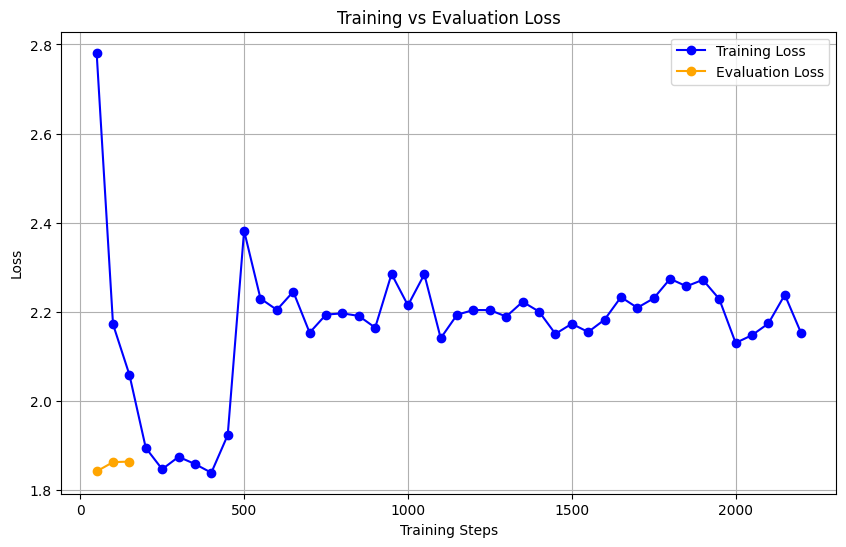

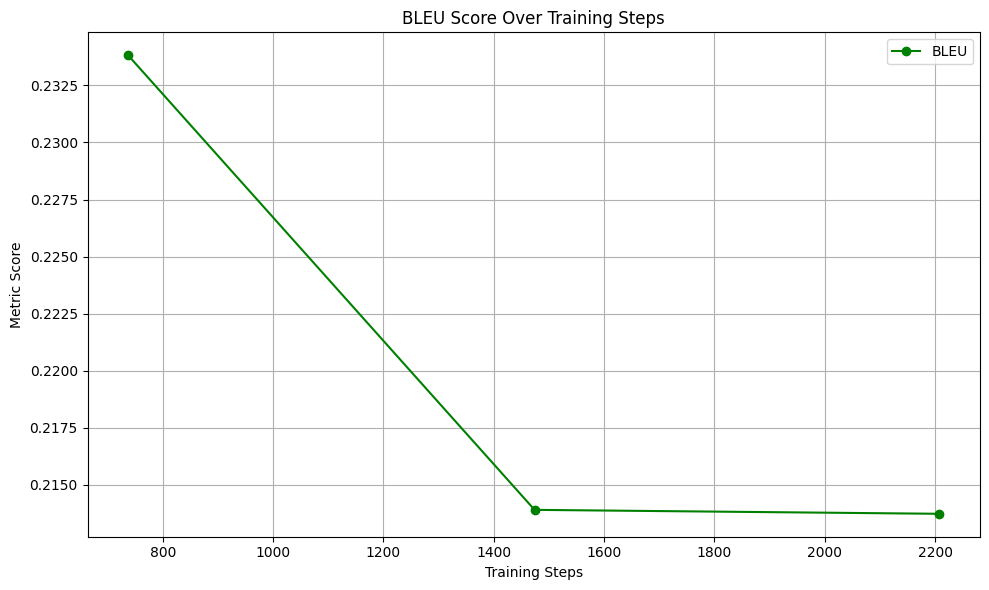

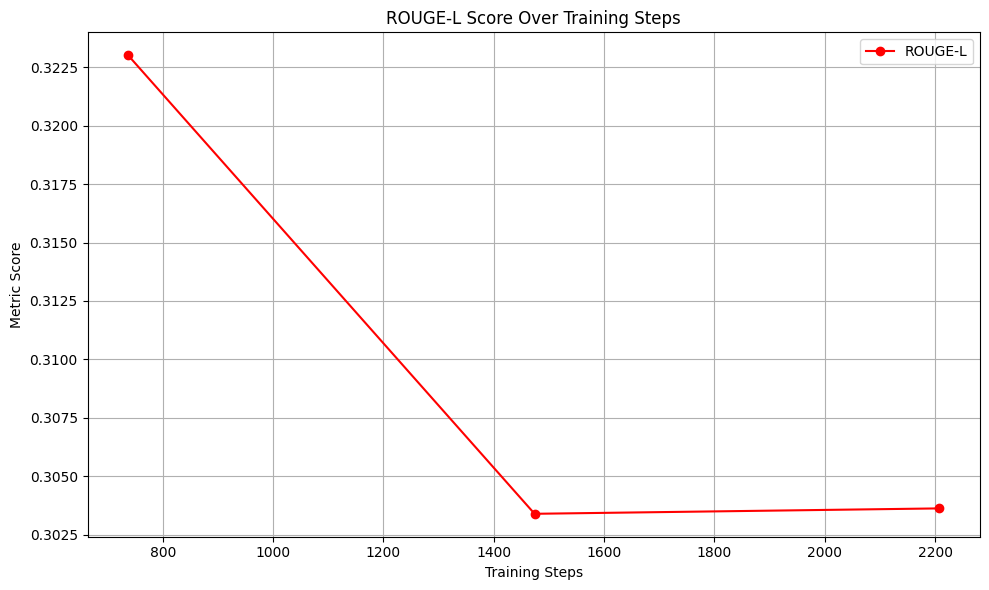

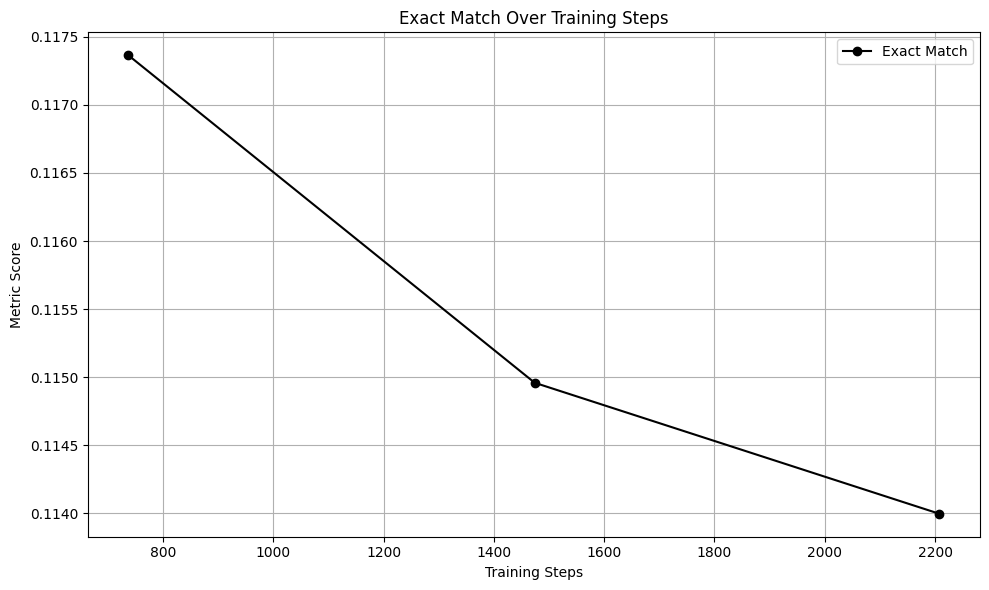

Question: What is Alzheimer's?
Response: Alzheimer's disease causes the risk factors for cognitive impairment and loss of memory skills in people with a rare memory disorder called vascular disorders of the brain. Alzheimers disease most often causes memory loss with speech loss syndrome syndrome. this disorder has been known since the mid 18th century. it can also cause brain


In [13]:
!pip install rouge-score sacrebleu evaluate torchsummary
!pip install --upgrade transformers sentencepiece
!pip uninstall -y protobuf
!pip install protobuf==3.20.*
!pip install --upgrade transformers datasets


# Import necessary libraries
import torch  # PyTorch for deep learning
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation
import re  # Regular expressions for text processing
import tensorflow as tf  # TensorFlow (not used in this script, but imported)
import evaluate  # Library for evaluation metrics
import seaborn as sns  # Seaborn for data visualization
import matplotlib.pyplot as plt  # Matplotlib for plotting
import warnings  # To suppress warnings

# Import Hugging Face Transformers components
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

# Import datasets for handling data
from datasets import Dataset

# Import scikit-learn for train-test split
from sklearn.model_selection import train_test_split

# Import PyTorch components for loss, optimization, and data handling
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

# Import defaultdict for handling dictionaries with default values
from collections import defaultdict

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

# Cargar el dataset desde un archivo CSV
df = pd.read_csv('/content/medquad.csv')

# Display a sample of the data to understand its structure
print("Data Sample:")
print(df.head())

# Check for null values in the dataset
print("Null Value Data:")
print(df.isnull().sum())

# Define a list of common question words to filter relevant questions
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Convert all questions to lowercase for consistent filtering
df['question'] = df['question'].str.lower()

# Filter rows where the question starts with one of the question words
df = df[df['question'].str.split().str[0].isin(question_words)]

# Reset the index after filtering
df = df.reset_index(drop=True)

# Check for duplicate rows in the dataset
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows to ensure data uniqueness
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

# Drop unused columns ('source' and 'focus_area') to simplify the dataset
df = df.drop(columns=['source', 'focus_area'])

# Display dataset information (columns, data types, and non-null counts)
print("Table Info:")
print(df.info())

# Remove duplicate rows based on the 'question' and 'answer' columns
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

# Drop rows with null values in the 'question' or 'answer' columns
df = df.dropna(subset=['question', 'answer']).reset_index(drop=True)

# Fill any remaining null values with empty strings and convert to string type
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Define a function to clean text by removing parentheses and extra spaces
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Remove text within parentheses
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Normalize spaces and convert to lowercase
    return text

# Apply the clean_text function to the 'question' and 'answer' columns
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Further clean the text by ensuring lowercase, stripping whitespace, and normalizing spaces
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

# Check for null values again after cleaning
print("Null Value Data After Cleaning:")
print(df.isnull().sum())

# Check the number of unique questions and answers in the dataset
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

# Display dataset information and a sample of the cleaned data
print("Final Dataset Info:")
df.info()
print("Final Data Sample:")
df.head()

# Define the model name and load the T5 configuration
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)

# Customize the configuration
config.dropout_rate = 0.1  # Set dropout rate to 0.1 for regularization
config.feed_forward_proj = "gelu"  # Use GELU activation for the feed-forward layers

# Load the pre-trained T5 model with the customized configuration
model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)

# Load the tokenizer for the T5 model
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Explicitly resize the token embeddings to match the tokenizer's vocabulary size
model.resize_token_embeddings(len(tokenizer))

# Print a detailed summary of the model architecture
print("\nDetailed Model Summary:")
print("=" * 50)

def summarize_model_by_type(model):
    """
    Summarizes the model by counting the number of layers and parameters for each layer type.
    """
    layer_summary = defaultdict(int)  # Counts the number of layers by type
    param_summary = defaultdict(int)  # Counts the number of parameters by layer type

    for name, module in model.named_modules():
        layer_type = type(module).__name__  # Get the type of the current module
        layer_summary[layer_type] += 1  # Increment the count for this layer type
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())  # Sum parameters

    # Print the summary table
    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Define a preprocessing function for the seq2seq task
def preprocess_function(batch):
    """
    Preprocesses the dataset by tokenizing the inputs and targets.
    """
    # Format the inputs and targets
    inputs = [f"answer the following question: {q}" for q in batch['question']]
    targets = [f"{a}" for a in batch['answer']]

    # Tokenize the inputs
    model_inputs = tokenizer(
        inputs,
        max_length=128,  # Truncate or pad to a maximum length of 128
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    # Tokenize the targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,  # Truncate or pad to a maximum length of 64
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

    # Replace padding token IDs with -100 for the loss function to ignore them
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convert the pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Preprocess the training and validation datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  # Process in batches of 32
    remove_columns=train_dataset.column_names,  # Remove original columns
    num_proc=2,  # Use 4 processes for parallel processing
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  # Process in batches of 32
    remove_columns=val_dataset.column_names,  # Remove original columns
    num_proc=4,  # Use 4 processes for parallel processing
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_total_limit=2,
    learning_rate=3e-4,  # Reducimos la tasa de aprendizaje
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    lr_scheduler_type="linear",  # Cambiamos a lineal
    warmup_ratio=0.1,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=False,  # Desactivamos fp16 para ver si evita el problema
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,  # Ajustamos la normalización del gradiente
    optim="adamw_torch_fused",
    generation_max_length=64,
    generation_num_beams=6,
    dataloader_num_workers=4,
    group_by_length=True,
    remove_unused_columns=False,  # No eliminar columnas por ahora
    label_smoothing_factor=0.0,  # Desactivamos label smoothing
)

# Initialize the data collator for seq2seq tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',  # Pad sequences to the longest in the batch
    return_tensors="pt",  # Return PyTorch tensors
)

# Define a function to compute evaluation metrics
def compute_metrics(eval_pred, tokenizer):
    """
    Computes exact match, BLEU, and ROUGE-L metrics for evaluation.
    """
    predictions, labels = eval_pred

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Normalize text for comparison
    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]

    # Compute exact match
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])

    # Load BLEU and ROUGE metrics
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")

    # Compute BLEU score
    bleu_score = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )["bleu"]

    # Compute ROUGE-L score
    rouge_score = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )["rougeL"]

    return {
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
    }

# Initialize the Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer),
)

# Train the model
trainer.train()

# Save the trained model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")

# Save the model's state dictionary
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save the training log history
log_history = trainer.state.log_history

# Initialize lists to store training and evaluation metrics
train_loss = []  # To store training loss values
eval_loss = []  # To store evaluation loss values
eval_bleu = []  # To store BLEU scores during evaluation
eval_exact_match = []  # To store exact match scores during evaluation
eval_rogue = []  # To store ROUGE-L scores during evaluation
steps = []  # To store training step numbers
eval_steps = []  # To store evaluation step numbers

# Extract metrics from the training log history
for log in log_history:
    if "loss" in log:  # Check if training loss is in the log
        train_loss.append(log["loss"])  # Append training loss
        steps.append(log["step"])  # Append the corresponding step number
    if "eval_loss" in log:  # Check if evaluation loss is in the log
        eval_loss.append(log["eval_loss"])  # Append evaluation loss
        eval_steps.append(log["step"])  # Append the corresponding step number
    if "eval_BLEU" in log:  # Check if BLEU score is in the log
        eval_bleu.append(log["eval_BLEU"])  # Append BLEU score
    if "eval_ROUGE-L" in log:  # Check if ROUGE-L score is in the log
        eval_rogue.append(log["eval_ROUGE-L"])  # Append ROUGE-L score
    if "eval_exact_match" in log:  # Check if exact match score is in the log
        eval_exact_match.append(log["eval_exact_match"])  # Append exact match score

# Plot the training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")  # Plot training loss
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")  # Plot evaluation loss
plt.xlabel("Training Steps")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Training vs Evaluation Loss")  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

# Plot the BLEU score over training steps
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")  # Plot BLEU score
plt.xlabel("Training Steps")  # X-axis label
plt.ylabel("Metric Score")  # Y-axis label
plt.title("BLEU Score Over Training Steps")  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot

# Plot the ROUGE-L score over training steps
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_rogue, label="ROUGE-L", marker="o", linestyle="-", color="red")  # Plot ROUGE-L score
plt.xlabel("Training Steps")  # X-axis label
plt.ylabel("Metric Score")  # Y-axis label
plt.title("ROUGE-L Score Over Training Steps")  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot

# Plot the exact match score over training steps
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_exact_match, label="Exact Match", marker="o", linestyle="-", color="black")  # Plot exact match score
plt.xlabel("Training Steps")  # X-axis label
plt.ylabel("Metric Score")  # Y-axis label
plt.title("Exact Match Over Training Steps")  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot

# Define paths to the saved model and tokenizer
model_path = "/content/t5_chatbot_model"
tokenizer_path = "/content/t5_chatbot_tokenizer"

# Load the tokenizer from the saved path
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

# Load the model from the saved path
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
    """
    Generates a response to a given question using Top-K and Top-P sampling.

    Args:
        question (str): The input question to generate a response for.
        model (T5ForConditionalGeneration): The pre-trained T5 model.
        tokenizer (T5Tokenizer): The tokenizer for the T5 model.
        max_length (int): Maximum length of the generated response.
        top_k (int): Number of highest probability tokens to consider for Top-K sampling.
        top_p (float): Cumulative probability threshold for Top-P (nucleus) sampling.
        temperature (float): Controls randomness in sampling (higher = more random).

    Returns:
        str: The generated response.
    """
    # Format the question for the model
    formatted_question = f"Answer the following question: {question}"

    # Tokenize the input question
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",  # Return PyTorch tensors
        padding=True,  # Pad sequences to the same length
        truncation=True,  # Truncate sequences longer than max_length
        max_length=128,  # Maximum length of the input sequence
    )

    # Generate a response using Top-K and Top-P sampling
    outputs = model.generate(
        input_ids=inputs["input_ids"],  # Input token IDs
        attention_mask=inputs["attention_mask"],  # Attention mask
        max_length=max_length,  # Maximum length of the generated response
        do_sample=True,  # Enable sampling instead of greedy/beam search
        top_k=top_k,  # Top-K sampling: consider the top-k tokens
        top_p=top_p,  # Top-P (nucleus) sampling: consider the smallest set of tokens with cumulative probability >= top_p
        temperature=temperature,  # Adjust randomness (higher values = more random)
        pad_token_id=tokenizer.pad_token_id,  # Token ID for padding
    )

    # Decode the generated response into a human-readable string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response

# Example usage of the function
question = "What is Alzheimer's?"
response = generate_response_top_k_top_p(question, model, tokenizer)

# Print the question and generated response
print("Question:", question)
print("Response:", response)



In [11]:
# Define paths to the saved model and tokenizer
model_path = "/content/t5_chatbot_model"
tokenizer_path = "/content/t5_chatbot_tokenizer"

# Load the tokenizer from the saved path
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

# Load the model from the saved path
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
    """
    Generates a response to a given question using Top-K and Top-P sampling.

    Args:
        question (str): The input question to generate a response for.
        model (T5ForConditionalGeneration): The pre-trained T5 model.
        tokenizer (T5Tokenizer): The tokenizer for the T5 model.
        max_length (int): Maximum length of the generated response.
        top_k (int): Number of highest probability tokens to consider for Top-K sampling.
        top_p (float): Cumulative probability threshold for Top-P (nucleus) sampling.
        temperature (float): Controls randomness in sampling (higher = more random).

    Returns:
        str: The generated response.
    """
    # Format the question for the model
    formatted_question = f"Answer the following question: {question}"

    # Tokenize the input question
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",  # Return PyTorch tensors
        padding=True,  # Pad sequences to the same length
        truncation=True,  # Truncate sequences longer than max_length
        max_length=128,  # Maximum length of the input sequence
    )

    # Generate a response using Top-K and Top-P sampling
    outputs = model.generate(
        input_ids=inputs["input_ids"],  # Input token IDs
        attention_mask=inputs["attention_mask"],  # Attention mask
        max_length=max_length,  # Maximum length of the generated response
        do_sample=True,  # Enable sampling instead of greedy/beam search
        top_k=top_k,  # Top-K sampling: consider the top-k tokens
        top_p=top_p,  # Top-P (nucleus) sampling: consider the smallest set of tokens with cumulative probability >= top_p
        temperature=temperature,  # Adjust randomness (higher values = more random)
        pad_token_id=tokenizer.pad_token_id,  # Token ID for padding
    )

    # Decode the generated response into a human-readable string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response

# Example usage of the function
question = "What is Alzheimer's?"
response = generate_response_top_k_top_p(question, model, tokenizer)

# Print the question and generated response
print("Question:", question)
print("Response:", response)

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [14]:
# Example usage of the function
question = "What is cancer?"
response = generate_response_top_k_top_p(question, model, tokenizer)

# Print the question and generated response
print("Question:", question)
print("Response:", response)

Question: What is cancer?
Response: a cancer occurs when cells invade tissue cells. the tumor is formed by a protein called cellular lymphocytes. lymphocytes are located on the brain walls of cells cells and are responsible for inflammation. Cancer cells are located beneath cells dividing cells that are located in the brain walls and spinal cord
